# Problem statement and data generation

For each class, there is one pattern occurring in the data. Solving just a classification task be scored no higher than 70%. 

Please provide either pdf with the report or add some notes in the notebook. Demonstrate some examples of how your approach works.

A short reminder of your task:
 - Correct classification of provided time series
 - Explanation of the prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
n = 50000

In [4]:
def createRow(n, classes):
    base = np.sin(np.linspace((np.random.rand(3)),(np.random.rand(3) + np.array([10,15,7])),n))
    if classes[0] > 0:
        base[np.random.randint(0,n), 0] += 2
    if classes[1] > 0:
        base[np.random.randint(0,n), 1] -= 2
    if classes[2] > 0:
        x = np.random.randint(0,n-5)
        base[x:x+4,2] = 0
    if classes[3] > 0:
        x = np.random.randint(0,n-10)
        base[x:x+8,1] += 1.5
    if classes[4] > 0:
        x = np.random.randint(0,n-7)
        base[x:x+6,0] += 1.5
        base[x:x+6,2] -= 1.5
    base += np.random.rand(*base.shape)*.2
    return base

In [5]:
xl, yl = [], []
for _ in range(n):
    cl = np.random.rand(5)<.25
    xl.append(createRow(np.random.randint(40,60), cl))
    yl.append(cl)
    

[False False False False  True]


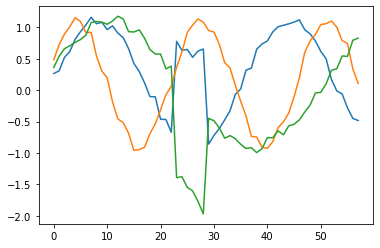

[False False False  True  True]


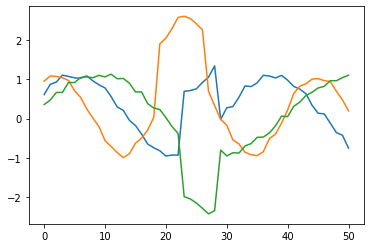

[False False False False False]


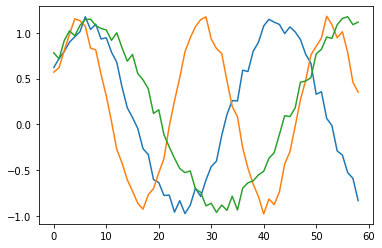

In [6]:
for i in range(3):
    plt.plot(xl[i])
    print(yl[i])
    plt.show()

---

In [7]:
import torch
import torch.nn as nn

from src.data import *
from src.metrics import *
from src.model import *
from src.utils import *

In [8]:
print(f"Is cuda available:\t{str(torch.cuda.is_available()).lower()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device:\t{device}")

Is cuda available:	true
Selected device:	cuda


# Dataset and dataloaders

| Set   |   %   |
|---    |---    |
| Train |   60  |
| Eval  |   20  |
| Test  |   20  | 

In [9]:
dataset = Dataset(xl, yl)
train, eval = dataset_split(dataset, train_size=0.6)
eval, test = dataset_split(eval, train_size=0.5)

In [10]:
train_dataloader = torch.utils.data.DataLoader(dataset=train, batch_size=1)
eval_dataloader = torch.utils.data.DataLoader(dataset=eval, batch_size=1)
test_dataloader = torch.utils.data.DataLoader(dataset=test, batch_size=1)

# Model
### Anomaly detector

In [11]:
clf = Classifier()
_ = clf.to(device)

In [12]:
epochs = 10
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(clf.parameters(), lr=1e-3, weight_decay=1e-4)

In [13]:
eval_f1 = []
for e in range(epochs):
    clf.train()
    ls = []
    for i, (x, y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        y_hat = clf(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ls.append(loss)
    print(f"Epoch: {e}")
    print(f"[train] Binary Cross Entropy: {sum(ls) / len(ls):.4f}")
    
    clf.eval()
    serialize(clf, e)
    with torch.no_grad():
        y_true, y_pred = [], []
        for i, (x, y) in enumerate(eval_dataloader):
            x = x.to(device)
            y_hat = clf(x)
            y_hat = y_hat.cpu()                
            y_true.append(y)
            y_pred.append(y_hat)
        
        y_true = torch.cat(y_true, dim=0)
        y_pred = torch.cat(y_pred, dim=0)
        (loss, acc, prec, rec, f1) = compute_metrics(y_true, y_pred)
        eval_f1.append(f1)
        
        print(f"[eval] Binary Cross Entropy: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")        
        if e >= 4 and all(np.array(eval_f1[-4:-1]) >= eval_f1[-1]):
            print(f"Early stopping")
            break

Epoch: 0
[train] Binary Cross Entropy: 0.3625
[eval] Binary Cross Entropy: 0.3389, Accuracy: 0.8482, Precision: 0.4384, Recall: 0.3054
Epoch: 1
[train] Binary Cross Entropy: 0.2520
[eval] Binary Cross Entropy: 0.1617, Accuracy: 0.9345, Precision: 0.6958, Recall: 0.6048
Epoch: 2
[train] Binary Cross Entropy: 0.0817
[eval] Binary Cross Entropy: 0.0380, Accuracy: 0.9889, Precision: 0.7599, Recall: 0.7546
Epoch: 3
[train] Binary Cross Entropy: 0.0296
[eval] Binary Cross Entropy: 0.0166, Accuracy: 0.9955, Precision: 0.7669, Recall: 0.7617
Epoch: 4
[train] Binary Cross Entropy: 0.0204
[eval] Binary Cross Entropy: 0.0154, Accuracy: 0.9961, Precision: 0.7674, Recall: 0.7629
Epoch: 5
[train] Binary Cross Entropy: 0.0152
[eval] Binary Cross Entropy: 0.0179, Accuracy: 0.9962, Precision: 0.7667, Recall: 0.7638
Epoch: 6
[train] Binary Cross Entropy: 0.0124
[eval] Binary Cross Entropy: 0.0101, Accuracy: 0.9974, Precision: 0.7686, Recall: 0.7639
Epoch: 7
[train] Binary Cross Entropy: 0.0113
[eval] Bi

In [14]:
clf.eval()
with torch.no_grad():
    y_true, y_pred = [], []
    for i, (x, y) in enumerate(test_dataloader):
        x = x.to(device)
        y_hat = clf(x)
        y_hat = y_hat.cpu()                
        y_true.append(y)
        y_pred.append(y_hat)
    
    y_true = torch.cat(y_true, dim=0)
    y_pred = torch.cat(y_pred, dim=0)
    (loss, acc, prec, rec, f1) = compute_metrics(y_true, y_pred)
        
    print(f"[test] Binary Cross Entropy: {loss:.4f}, Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")        
    

[test] Binary Cross Entropy: 0.6933, Accuracy: 0.7523, Precision: 0.0000, Recall: 0.0000


In [15]:
clf = deserialize('2022-01-04-21:43:48.092987-epoch-7.pt')
_ = clf.to(device)

### Time series reconstructor

$\text{model} = a + sin{(b\times x + c)}$

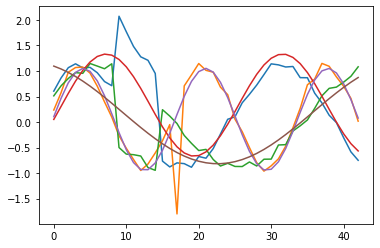

In [16]:
plt.plot(xl[42])
plt.plot(reconstruct(xl[42]))
plt.show()

### Root cause analysis
Detecting on which time series (variable) which anomaly occurs. 

`result = [anomaly_type, time_series]`

`result = [[], [], [], [2], []]` - there is one anomaly of type 4 and it occurs on time series number 2



In [17]:
anomaly_on_ts(xl[42], clf)

[[], [1], [], [], [0, 2]]

In [19]:
yl[42]

array([False,  True, False, False,  True])